In [14]:
from dotenv import load_dotenv
load_dotenv()

import uuid
from typing import List
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore


In [15]:
store = InMemoryStore()


In [16]:
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.

If user-specific memory is available, personalize your responses.

Always:
- Address the user by name if known
- Refer to known projects, profession, or preferences
- Keep tone friendly and tailored

The user’s memory is:
{user_details}

At the end, suggest 3 relevant follow-up questions.
"""


In [17]:
import os
memory_llm = ChatOpenAI(
    model="xiaomi/mimo-v2-flash:free",
    api_key=os.environ.get('OPEN_ROUTER_API_KEY'),
    base_url="https://openrouter.ai/api/v1",
)

class MemoryItem(BaseModel):
    text: str = Field(description="Atomic user memory")
    is_new: bool = Field(description="True if this is new information")

class MemoryDecision(BaseModel):
    should_write: bool | None = None
    memories: List[MemoryItem] = Field(default_factory=list)


memory_extractor = memory_llm.with_structured_output(MemoryDecision)

MEMORY_PROMPT = """You are responsible for maintaining accurate long-term user memory.

CURRENT MEMORY:
{existing}

TASK:
Extract stable user facts (name, profession, preferences, ongoing projects).
Mark is_new=true ONLY if meaning is not already present.
No assumptions. Short atomic sentences.
"""


In [18]:
def remember_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("user", user_id, "details")

    items = store.search(namespace)
    existing = "\n".join(it.value["data"] for it in items) if items else "(empty)"

    last_msg = state["messages"][-1].content

    try:
        decision: MemoryDecision = memory_extractor.invoke(
            [
                SystemMessage(content=MEMORY_PROMPT.format(existing=existing)),
                {"role": "user", "content": last_msg}
            ]
        )
    except Exception as e:
        print("⚠️ Memory extraction failed:", e)
        return {}

    # ✅ Auto-infer should_write if model forgot it
    should_write = decision.should_write
    if should_write is None:
        should_write = len(decision.memories) > 0

    if should_write:
        for mem in decision.memories:
            if mem.is_new and mem.text.strip():
                store.put(namespace, str(uuid.uuid4()), {"data": mem.text.strip()})

    return {}



In [19]:
import os
from dotenv import load_dotenv
load_dotenv()

chat_llm = ChatOpenAI(
    model="xiaomi/mimo-v2-flash:free",
    api_key=os.environ.get('OPEN_ROUTER_API_KEY'),
    base_url="https://openrouter.ai/api/v1",
)
print(os.environ.get('OPEN_ROUTER_API_KEY'))

def chat_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("user", user_id, "details")

    items = store.search(namespace)
    user_details = "\n".join(it.value["data"] for it in items) if items else "(empty)"

    system_msg = SystemMessage(
        content=SYSTEM_PROMPT_TEMPLATE.format(user_details=user_details)
    )

    response = chat_llm.invoke([system_msg] + state["messages"])
    return {"messages": [response]}


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


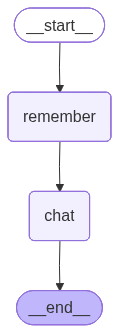

In [20]:
builder = StateGraph(MessagesState)

builder.add_node("remember", remember_node)
builder.add_node("chat", chat_node)

builder.add_edge(START, "remember")
builder.add_edge("remember", "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)
graph


In [21]:
config = {"configurable": {"user_id": "u1"}}

res = graph.invoke({"messages":[{"role":"user","content":"Hi, my name is Nitish"}]}, config)
print(res["messages"][-1].content)

res = graph.invoke({"messages":[{"role":"user","content":"I teach AI on YouTube"}]}, config)
print(res["messages"][-1].content)

res = graph.invoke({"messages":[{"role":"user","content":"Explain GenAI simply"}]}, config)
print(res["messages"][-1].content)


Hi Nitish! It's great to meet you. Since I don't have any prior memories about you, I'd love to learn more. What brings you here today?
Hey, that's fantastic—teaching AI on YouTube is such a vital and exciting space right now. With how fast AI is evolving, your content could really help a ton of people wrap their heads around it, from beginners to more advanced folks. I'd love to hear more about your channel—what's your niche within AI? Like, do you focus on practical coding tutorials, ethical discussions, or something else? Also, any favorite video you've made that got a great response?

If you're looking for ideas or help with scripting, explaining concepts, or even optimizing your channel, just let me know. What's one thing you're working on for your next video?
**Generative AI (GenAI) in simple terms:**

GenAI is like a super-smart digital assistant that can **create new things** based on what it's learned. Instead of just answering questions or following rules, it generates origin